In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import  preprocess_input

2024-05-05 17:59:05.170939: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 17:59:05.725782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 17:59:05.725818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 17:59:05.823457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 17:59:06.027281: I tensorflow/core/platform/cpu_feature_guar

In [14]:
src_path_train = "./Data/train/"
src_path_valid = "./Data/valid/"
src_path_test = "./Data/test/"

scale=1
rotation=20
zoom=0.25
width_shift=0.25
height_shift=0.25
shear=0.25

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,
        rotation_range=rotation,
        # zoom_range=zoom,
        width_shift_range=width_shift,
        height_shift_range=width_shift,
        shear_range=shear,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,    
        dtype='float32',
        rescale=scale,) 

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,)

In [15]:
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory=src_path_valid,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

In [17]:
NUM_CLASSES = 4

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
HIDDEN_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 1

BATCH_SIZE_TESTING = 1

STEPS_PER_EPOCH_TRAINING = 20
STEPS_PER_EPOCH_VALIDATION = 1

In [18]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [19]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23604100 (90.04 MB)
Trainable params: 12292 (48.02 KB)
Non-trainable params: 23591808 (90.00 MB)
_________________________________________________________________


In [20]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [21]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = './models/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [22]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.2229 - accuracy: 0.5612

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 7s 266ms/step - loss: 1.2229 - accuracy: 0.5612 - val_loss: 1.4204 - val_accuracy: 0.5938
Epoch 2/50
20/20 [==============================] - 5s 239ms/step - loss: 0.8182 - accuracy: 0.7537 - val_loss: 1.9269 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 5s 249ms/step - loss: 0.5717 - accuracy: 0.8124 - val_loss: 0.9083 - val_accuracy: 0.7812
Epoch 4/50
20/20 [==============================] - 5s 237ms/step - loss: 0.6557 - accuracy: 0.8254 - val_loss: 0.9602 - val_accuracy: 0.6875
Epoch 5/50
20/20 [==============================] - 5s 237ms/step - loss: 0.4828 - accuracy: 0.8189 - val_loss: 1.2407 - val_accuracy: 0.7500
Epoch 6/50
20/20 [==============================] - 5s 251ms/step - loss: 0.5091 - accuracy: 0.8564 - val_loss: 0.8316 - val_accuracy: 0.8125
Epoch 7/50
20/20 [==============================] - 5s 239ms/step - loss: 0.4302 - accuracy: 0.8499 - val_loss: 1.7770 - val_accuracy: 0.6250
Epoch 8/50
20/20 

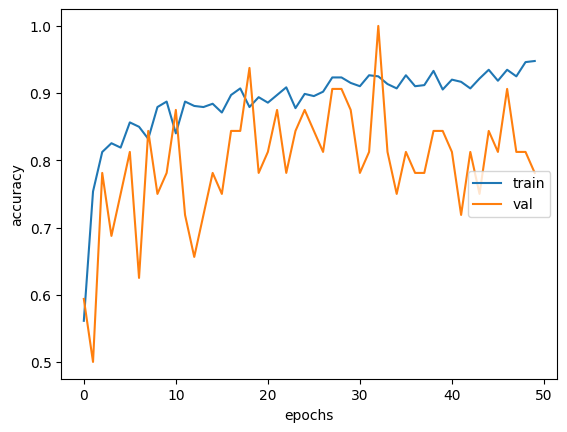

In [23]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [24]:
model.load_weights(filepath='./models/best.hdf5')
model.evaluate(test_generator)

315/315 [==============================] - 5s 16ms/step - loss: 1.1915 - accuracy: 0.7778


[1.1914657354354858, 0.7777777910232544]